# Проект 3: Сравнение тарифов "Смарт" и "Ультра" компании "Мегалайн"

### Цель:
Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов:

#### Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»

1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей


### Описание данных:

##### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

##### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

##### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

##### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

##### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from math import factorial
import math

### <span style="color:blue"> Шаг 1: Чтение файлов и сводная информация<span>

#### Таблица с информацией о звонках

In [2]:
cal = pd.read_csv('/datasets/calls.csv')
cal.info()
cal.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
77976,1196_208,2018-11-10,11.43,1196
122404,1316_25,2018-12-27,3.46,1316
161806,1396_507,2018-08-20,12.70,1396
30288,1076_580,2018-07-04,0.00,1076
44681,1113_97,2018-09-20,13.22,1113


#### Таблица с информацией об интернет сессиях

In [3]:
inet = pd.read_csv('/datasets/internet.csv')
inet.info()
inet.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
146644,146644,1490_387,175.90,2018-05-04,1490
85140,85140,1290_170,376.24,2018-08-25,1290
51982,51982,1176_137,717.03,2018-09-15,1176
87019,87019,1294_361,434.91,2018-06-07,1294
43271,43271,1149_271,0.00,2018-08-28,1149


In [4]:
#сразу удалю непонятный столбец, дублирующий индексы
inet.drop(['Unnamed: 0'], axis='columns', inplace=True)

#### Таблица с информацией о сообщениях

In [5]:
mes = pd.read_csv('/datasets/messages.csv')
mes.info()
mes.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
122049,1495_224,2018-12-10,1495
21478,1091_31,2018-08-19,1091
20004,1089_7,2018-07-03,1089
36378,1158_183,2018-09-20,1158
46161,1200_56,2018-12-28,1200


#### Таблица с информацией о тарифах

In [6]:
tar = pd.read_csv('/datasets/tariffs.csv')
tar.info()
tar.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Таблица с информацией о пользователях

In [7]:
us = pd.read_csv('/datasets/users.csv')
us.info()
us.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
168,1168,28,NaN,Кострома,Лилия,Ананьева,2018-01-24,ultra
148,1148,23,NaN,Тольятти,Евдокия,Киреева,2018-04-17,ultra
273,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra
206,1206,35,2018-12-20,Москва,Елена,Шарапова,2018-11-03,smart
141,1141,52,NaN,Москва,Клариса,Короткова,2018-12-02,smart


### <span style="color:blue"> Шаг 2: Подготовка данных <span>

В таблицах cal, inet, mes есть столбец id, который называется одинаково, но харрактирезует данные конкретной таблицы, поэтому я переименую их соответственно в cal_id, inet_id, mes_id, чтобы данные не перемешались при последующем объединении таблиц. Также переименовываю столбец с тарифами в таблице с пользователями, чтобы назывался также как столбец в таблице тарифов.

In [8]:
cal.rename(columns={'id': 'cal_id'}, inplace=True)
inet.rename(columns={'id': 'inet_id'}, inplace=True)
mes.rename(columns={'id': 'mes_id'}, inplace=True)
us.rename(columns={'tariff': 'tariff_name'}, inplace=True)

##### Изменение типов данных

Столбцы с датами привожу к соответствующему формату.

In [9]:
cal['call_date'] = pd.to_datetime(cal['call_date'], format='%Y.%m.%d')
inet['session_date'] = pd.to_datetime(inet['session_date'], format='%Y.%m.%d')
mes['message_date'] = pd.to_datetime(mes['message_date'], format='%Y.%m.%d')
us['reg_date'] = pd.to_datetime(us['reg_date'], format='%Y.%m.%d')

##### Анализ длительности звонков

Смотрю сколько обычно разговаривают пользователи и сколько пропущенных звонков.

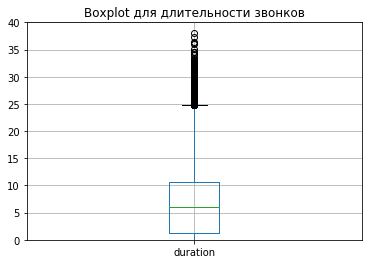

In [10]:
plt.ylim(0, 40.0)
cal.boxplot('duration')
plt.title('Boxplot для длительности звонков', fontsize=12)
plt.show()

In [11]:
(cal['duration'] == 0).sum()

39613

Пропущенных звонков почти 20% от общего количества. Мне кажется, что это большой процент, убирать их не стоит. Возможно, они исказят данные об активности пользователей.

##### Анализ интернет трафика

In [12]:
(inet['mb_used']==0).sum()

19598

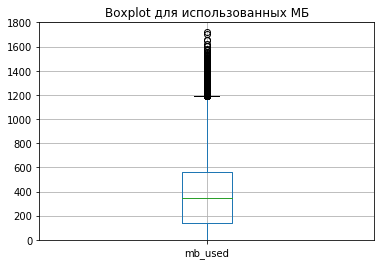

In [13]:
plt.ylim(0, 1800)
inet.boxplot('mb_used')
plt.title('Boxplot для использованных МБ', fontsize=12)
plt.show()

In [14]:
inet.query('mb_used ==0 and user_id == 1000').pivot_table(index=('user_id', 'session_date'), values='mb_used', aggfunc='sum')

mb_used
user_id session_date         
1000    2018-05-26        0.0
        2018-06-15        0.0
        2018-06-16        0.0
        2018-06-17        0.0
        2018-06-30        0.0
        2018-07-11        0.0
        2018-08-21        0.0
        2018-08-28        0.0
        2018-09-01        0.0
        2018-09-17        0.0
        2018-11-27        0.0
        2018-12-21        0.0
        2018-12-29        0.0

Посмотрела на примере одного пользователя. Выглядит так, как будто он в каие то дни не пользовался интернетом. Но тогда странно, что в таблице есть id сессии. Для меня сессия - это сеанс в интернете, то есть он должен был пользоваться интернетом. Решила убрать из данных нулевые значения.

In [15]:
inet = inet.query('mb_used != 0')

##### Объединение таблиц

Сначала добавила к таблицам с информацией о звонках, сообщениях, трафику, таблицу с данными о пользователях.

In [16]:
df1 = pd.merge(us, cal, how = 'inner', on = 'user_id') 
df2 = pd.merge(us, mes, how = 'inner', on = 'user_id')
df3 = pd.merge(us, inet, how = 'inner', on = 'user_id')

df1.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,cal_id,call_date,duration
38805,1097,29,NaN,Краснодар,Алла,Кулешова,2018-06-25,ultra,1097_137,2018-11-06,14.59
159523,1393,56,NaN,Краснодар,Артём,Зубков,2018-02-17,smart,1393_775,2018-03-02,13.07
11635,1030,28,NaN,Махачкала,Мариетта,Русанова,2018-05-23,smart,1030_168,2018-06-30,15.05
58508,1147,63,NaN,Якутск,Владимир,Синицын,2018-07-09,smart,1147_223,2018-11-05,7.52
8680,1021,61,NaN,Краснодар,Святослав,Тихонов,2018-04-26,ultra,1021_1148,2018-05-21,0.00


Потом добавила информацио о соответствующем тарифе.

In [17]:
# таблица с информацией по звонкам пользователей, с указанием их тарифа 
df_cal = pd.merge(df1, tar, how = 'inner', on = 'tariff_name')
# таблица с информацией по сообщениям пользователей, с указанием их тарифа 
df_mes = pd.merge(df2, tar, how = 'inner', on = 'tariff_name')
# таблица с информацией по интернет-траффику пользователей, с указанием их тарифа 
df_inet = pd.merge(df3, tar, how = 'inner', on = 'tariff_name')

df_cal.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,cal_id,call_date,duration,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
171880,1388,24,NaN,Вологда,Рустам,Левин,2018-08-27,smart,1388_166,2018-11-06,0.72,50,15360,500,550,200,3,3
16668,1126,71,NaN,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra,1126_485,2018-02-26,4.65,1000,30720,3000,1950,150,1,1
38109,1325,63,NaN,Новосибирск,Артём,Федосеев,2018-06-12,ultra,1325_94,2018-11-12,0.00,1000,30720,3000,1950,150,1,1
88061,1059,47,NaN,Курск,Глеб,Свиридов,2018-04-14,smart,1059_398,2018-12-01,0.00,50,15360,500,550,200,3,3
149922,1285,44,NaN,Краснодар,Ефим,Амельченко,2018-02-20,smart,1285_372,2018-10-27,0.00,50,15360,500,550,200,3,3
107950,1133,70,NaN,Барнаул,Надежда,Аникина,2018-10-19,smart,1133_6,2018-11-18,6.71,50,15360,500,550,200,3,3
88454,1061,41,NaN,Санкт-Петербург,Тамара,Ситникова,2018-07-15,smart,1061_17,2018-09-11,5.93,50,15360,500,550,200,3,3
126088,1193,55,NaN,Тамбов,Арсен,Безруков,2018-01-01,smart,1193_524,2018-08-03,5.58,50,15360,500,550,200,3,3
146501,1275,48,NaN,Москва,Семён,Елизаров,2018-04-24,smart,1275_336,2018-08-05,16.78,50,15360,500,550,200,3,3
92675,1072,49,NaN,Уфа,Андрей,Андрейкин,2018-02-20,smart,1072_404,2018-05-08,1.17,50,15360,500,550,200,3,3


### Количество сделанных звонков и израсходованных минут разговора по месяцам

Добавляю столбцы со значением месяца и года, хотя наверное год можно было и не добавлять, все данные и так за 2018 год.

In [18]:
df_cal['month'] = pd.DatetimeIndex(df_cal['call_date']).month
df_cal['year'] = pd.DatetimeIndex(df_cal['call_date']).year

In [19]:
df_cal.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,cal_id,call_date,duration,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,year
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.00,1000,30720,3000,1950,150,1,1,7,2018
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.00,1000,30720,3000,1950,150,1,1,8,2018
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,2.85,1000,30720,3000,1950,150,1,1,6,2018
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,13.80,1000,30720,3000,1950,150,1,1,9,2018
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,5.18,1000,30720,3000,1950,150,1,1,12,2018


#### Сводная таблица по месяцам и пользователям

In [20]:
#округляю длительность
df_cal['duration'] = df_cal['duration'].apply(lambda x: int(math.ceil(x)))

In [21]:
df_cal.pivot_table(index=['month', 'user_id'], values='duration', aggfunc=('count', 'sum'))

count   sum
month user_id             
1     1005        15    95
      1032        61   380
      1045         1     9
      1055        64   551
      1071        24   194
...              ...   ...
12    1494        62   418
      1495       155  1031
      1496        80   518
      1497        71   545
      1499        69   492

[3174 rows x 2 columns]

Построила график распределения звонков по длительности.

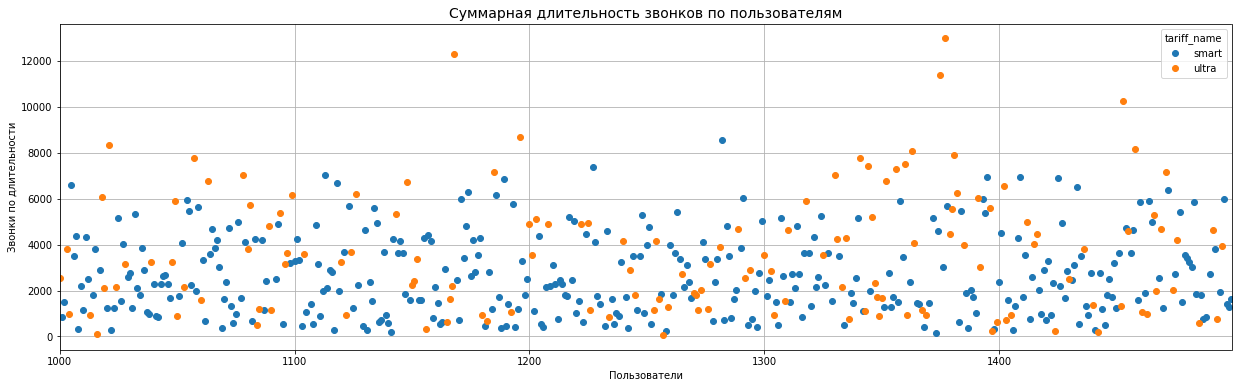

In [22]:
df_cal.pivot_table(index=['user_id'], columns = 'tariff_name', values='duration', aggfunc='sum').plot(grid=True, figsize=(21, 6), style='o')
plt.title('Суммарная длительность звонков по пользователям', fontsize=14)
plt.ylabel("Звонки по длительности")
plt.xlabel("Пользователи")

plt.show()

Построила график по количеству звонков пользователей разных тарифов.

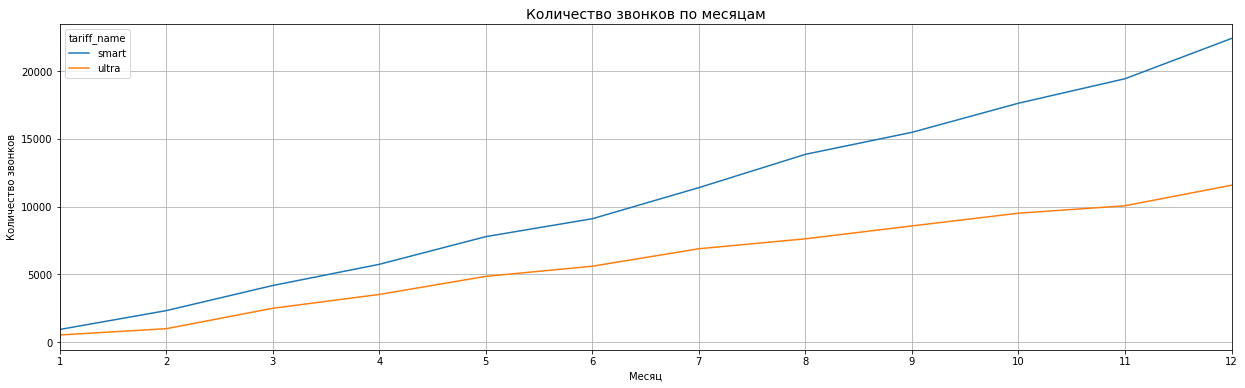

In [23]:
length=12
xmarks=[i for i in range(1,length+1,1)]

df_cal.pivot_table(index='month', columns = 'tariff_name', values='cal_id', aggfunc='count').plot(grid=True, figsize=(21, 6))
plt.title('Количество звонков по месяцам', fontsize=14)
plt.ylabel("Количество звонков")
plt.xlabel("Месяц")
plt.xticks(xmarks)
plt.show()

In [24]:
# количество пользователей по тарифам
us['tariff_name']. value_counts()

smart    351
ultra    149
Name: tariff_name, dtype: int64

#### Вывод:
У пользователей тарифа "Ультра" более длительные звонки. Количество звонков у пользователей тарифа "Смарт" большое, но и количество пользователей в 2,3 раза больше чем у "Ультра".

### Количество сообщений по месяцам

In [25]:
df_mes['month'] = pd.DatetimeIndex(df_mes['message_date']).month
df_mes.pivot_table(index=['month', 'user_id'], values='mes_id', aggfunc='count')

mes_id
month user_id        
1     1005          7
      1032         38
      1045          5
      1055         30
      1071         16
...               ...
12    1493         78
      1495         84
      1496         51
      1497         17
      1499         66

[2717 rows x 1 columns]

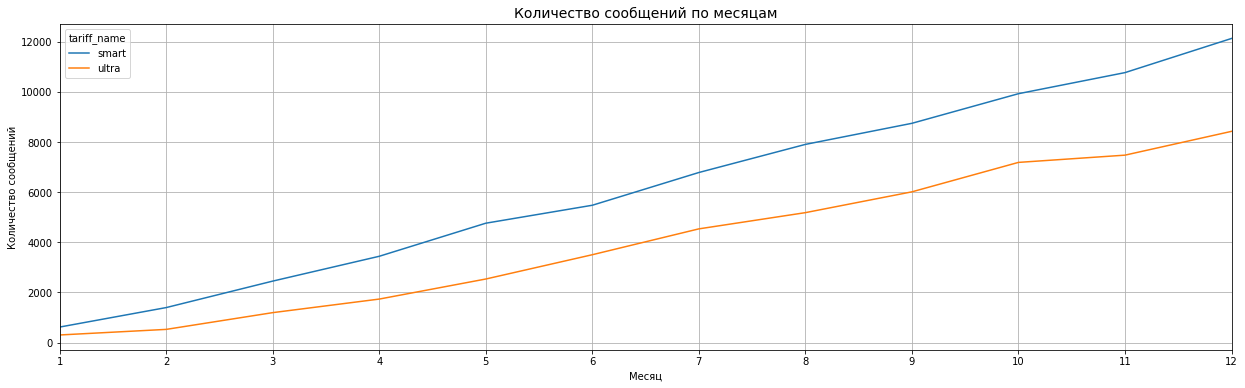

In [26]:
length=12
xmarks=[i for i in range(1,length+1,1)]

df_mes.pivot_table(index=['month'], columns = 'tariff_name', values='mes_id', aggfunc='count').plot(grid=True, figsize=(21, 6))
plt.title('Количество сообщений по месяцам', fontsize=14)
plt.ylabel("Количество сообщений")
plt.xlabel("Месяц")
plt.xticks(xmarks)
plt.show()

Пользователи тарифа "Смарт" отправляют больше сообщений, но думаю это из за количества самих пользователлей. Линии на графике идут практически параллельно, то есть по активности отправки сообщений, пользователи тарифа "Ультра" не сильно уступают.

### Объем израсходованного интернет-трафика по месяцам

In [27]:
df_inet['month'] = pd.DatetimeIndex(df_inet['session_date']).month
df_inet.pivot_table(index=['month', 'user_id'], values='mb_used', aggfunc=('count', 'sum'))

count       sum
month user_id                 
1     1005         6   2727.97
      1032        51  24127.69
      1045         5   2346.71
      1055        43  17090.88
      1071        37  15604.34
...              ...       ...
12    1494        44  17621.21
      1495        46  23426.76
      1496        55  20736.15
      1497        41  19918.60
      1499        40  13055.58

[3201 rows x 2 columns]

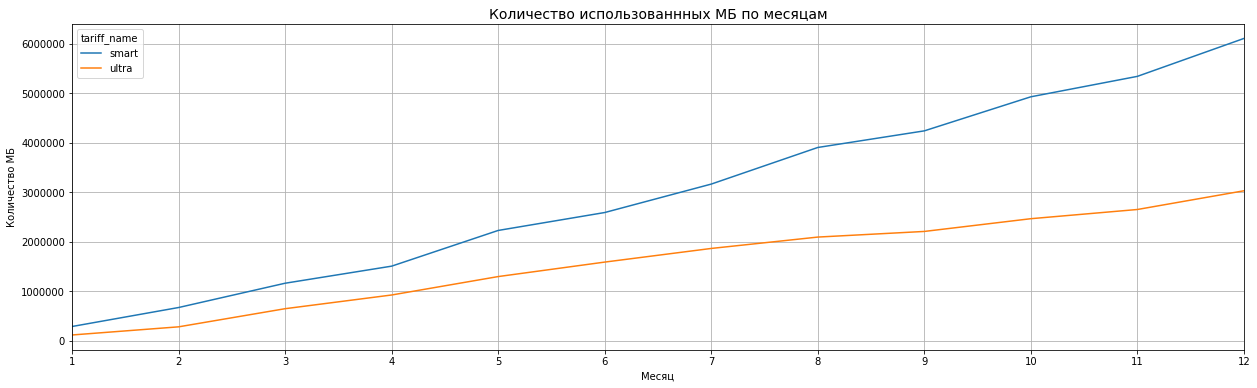

In [28]:
length=12
xmarks=[i for i in range(1,length+1,1)]

df_inet.pivot_table(index='month', columns = 'tariff_name', values='mb_used', aggfunc='sum').plot(grid=True, figsize=(21, 6))
plt.title('Количество использованнных МБ по месяцам', fontsize=14)
plt.ylabel("Количество МБ")
plt.xlabel("Месяц")
plt.xticks(xmarks)
plt.show()

На графике линии больше расходятся, то есть пользователи тарифа "Смарт" более активно расходуют МБ.

### Помесячная выручка

Для того, чтобы проанаизировать выручку, сделаю объединение таблиц по пользователям и месяцам.

In [29]:
#сделала подсчитанную по месяцам таблицу с длительностью звонков
m_cal = df_cal.groupby(['user_id', 'month'])[['duration']].agg(['sum']).reset_index()
m_cal.columns=['user_id', 'month', 'duration']            
m_cal.head()
m_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 3 columns):
user_id     3174 non-null int64
month       3174 non-null int64
duration    3174 non-null int64
dtypes: int64(3)
memory usage: 74.5 KB


In [30]:
#сделала подсчитанную по месяцам таблицу с количеством сообщений
m_mes = df_mes.groupby(['user_id','month'])[['mes_id']].agg(['count']).reset_index()
m_mes.columns=['user_id', 'month', 'count_mes']            
m_mes.head()
m_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
user_id      2717 non-null int64
month        2717 non-null int64
count_mes    2717 non-null int64
dtypes: int64(3)
memory usage: 63.8 KB


In [31]:
#сделала подсчитанную по месяцам таблицу с использованным трафиком
m_inet = df_inet.groupby(['user_id','month', 'tariff_name'])[['mb_used']].agg(['sum']).reset_index()
m_inet.columns=['user_id', 'month', 'tariff_name', 'mb_used']            
m_inet.head()
m_inet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 4 columns):
user_id        3201 non-null int64
month          3201 non-null int64
tariff_name    3201 non-null object
mb_used        3201 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 100.2+ KB


In [32]:
#добавила информацию о тарифах
m_inet = pd.merge(m_inet, tar, how = 'inner', on = 'tariff_name')

In [33]:
#объединяю таблицы по двум столбцам пользователю и месяцу
df1 = m_inet.merge(m_cal, how='left', on=['user_id', 'month'])
df = df1.merge(m_mes, how='left', on=['user_id', 'month'])
df.head()

,user_id,month,tariff_name,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration,count_mes
0,1000,5,ultra,2253.49,1000,30720,3000,1950,150,1,1,159.0,22.0
1,1000,6,ultra,23233.77,1000,30720,3000,1950,150,1,1,172.0,60.0
2,1000,7,ultra,14003.64,1000,30720,3000,1950,150,1,1,340.0,75.0
3,1000,8,ultra,14055.93,1000,30720,3000,1950,150,1,1,408.0,81.0
4,1000,9,ultra,14568.91,1000,30720,3000,1950,150,1,1,466.0,57.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 13 columns):
user_id                  3201 non-null int64
month                    3201 non-null int64
tariff_name              3201 non-null object
mb_used                  3201 non-null float64
messages_included        3201 non-null int64
mb_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minute           3201 non-null int64
duration                 3161 non-null float64
count_mes                2704 non-null float64
dtypes: float64(3), int64(9), object(1)
memory usage: 350.1+ KB


In [35]:
df['duration']=df['duration'].fillna(0)
df['count_mes']=df['count_mes'].fillna(0)

Теперь в одной таблице информация по пользователю, его тарифу, месяцам и соответсвующим месяцу количеству сообщений, длительности звонков и потраченному трафику.

#####  Выручка по звонкам сверх тарифа

Считаю сколько денег сверх тарифа пользователь должен заплатить. Если значение меньше нуля, значит пользователь не превысил лимит тарифа по звонкам. Плюсовое значение это сумма в рублях, которую пользователь должен доплатить сверх ежемесячной платы.

In [36]:
df['proceeds_cal']=(df['duration']-df['minutes_included'])*df['rub_per_minute']
df['proceeds_cal'].sample(10)

2457     771.0
341    -2419.0
627    -1792.0
1721    -909.0
1412     285.0
182    -2555.0
1113    -183.0
1987     -15.0
1986    -111.0
1478       3.0
Name: proceeds_cal, dtype: float64

In [37]:
# проверяю на наличие пропущенных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 14 columns):
user_id                  3201 non-null int64
month                    3201 non-null int64
tariff_name              3201 non-null object
mb_used                  3201 non-null float64
messages_included        3201 non-null int64
mb_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minute           3201 non-null int64
duration                 3201 non-null float64
count_mes                3201 non-null float64
proceeds_cal             3201 non-null float64
dtypes: float64(4), int64(9), object(1)
memory usage: 375.1+ KB


Есть пропущенные значения в сообщениях и трафике, предполагаю, что пользователи могли в какой либо месяц не посылать смс и не заходить в интернет.

#####  Выручка по сообщениям сверх тарифа

In [38]:
df['proceeds_mes']=(df['count_mes']-df['messages_included'])*df['rub_per_message']
df['proceeds_mes'].sample(10)

1857   -129.0
1510   -150.0
1786   -150.0
340    -956.0
2157   -126.0
2814     18.0
2385    -72.0
1808    -93.0
3073    -87.0
837    -917.0
Name: proceeds_mes, dtype: float64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 15 columns):
user_id                  3201 non-null int64
month                    3201 non-null int64
tariff_name              3201 non-null object
mb_used                  3201 non-null float64
messages_included        3201 non-null int64
mb_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minute           3201 non-null int64
duration                 3201 non-null float64
count_mes                3201 non-null float64
proceeds_cal             3201 non-null float64
proceeds_mes             3201 non-null float64
dtypes: float64(5), int64(9), object(1)
memory usage: 400.1+ KB


In [40]:
df['proceeds_mes']=df['proceeds_mes'].fillna(0)

В какие то месяца пользователи не отправляли смс, поэтому заполнила выручку по сообщениям сверх тарифа нулями.

#####  Выручка по интернет-трафику сверх тарифа

In [41]:
df['proceeds_inet']=(df['mb_used']-df['mb_per_month_included'])*df['rub_per_gb']/1024
df['proceeds_inet'].sample(10)

2240    -308.708984
2707   -1704.583984
1326    1826.468750
1985     126.263672
423    -1652.701172
283     1673.506348
817     1300.423828
248    -1515.767578
1474   -2850.347656
93     -2404.971680
Name: proceeds_inet, dtype: float64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 16 columns):
user_id                  3201 non-null int64
month                    3201 non-null int64
tariff_name              3201 non-null object
mb_used                  3201 non-null float64
messages_included        3201 non-null int64
mb_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minute           3201 non-null int64
duration                 3201 non-null float64
count_mes                3201 non-null float64
proceeds_cal             3201 non-null float64
proceeds_mes             3201 non-null float64
proceeds_inet            3201 non-null float64
dtypes: float64(6), int64(9), object(1)
memory usage: 425.1+ KB


In [43]:
df['proceeds_inet']=df['proceeds_inet'].fillna(0)

Аналогично подчитала выручку для использованного сверх лимита трафика и заменила пропуски на 0.

#### Подсчет общей выручки

Тут ниже функция, которая возвращает ту плату, которую абонент должен заплатить в месяц.
Если абонент не привысил лимит ни по одному пункту (то есть все показатели меньше или равны 0), то обычная ежемесячная плата, если привысил, то ежемесячная плата плюс соответствующая рассчетная плата сверх тарифа.
Возможно выглядит убого, но вроде бы работает.

Функцию убрала, заменила отрицательные на 0 и сложила все.

In [44]:
df['proceeds_cal']=df['proceeds_cal'].clip(lower=0)
df['proceeds_mes']=df['proceeds_mes'].clip(lower=0)
df['proceeds_inet']=df['proceeds_inet'].clip(lower=0)
    
#новый столбец с общей выручкой    
df['total_proceed']= df['proceeds_cal'] + df['proceeds_mes'] + df['proceeds_inet'] + df['rub_monthly_fee']
    
df.sample(10)    
       

,user_id,month,tariff_name,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration,count_mes,proceeds_cal,proceeds_mes,proceeds_inet,total_proceed
2835,1422,11,smart,8449.47,50,15360,500,550,200,3,3,412.0,42.0,0.0,0.0,0.000000,550.000000
2267,1284,5,smart,20066.01,50,15360,500,550,200,3,3,631.0,36.0,393.0,0.0,919.142578,1862.142578
2263,1283,11,smart,18842.55,50,15360,500,550,200,3,3,264.0,19.0,0.0,0.0,680.185547,1230.185547
2005,1219,11,smart,21571.78,50,15360,500,550,200,3,3,463.0,7.0,0.0,0.0,1213.238281,1763.238281
3069,1475,5,smart,13670.79,50,15360,500,550,200,3,3,291.0,30.0,0.0,0.0,0.000000,550.000000
3038,1465,12,smart,16613.91,50,15360,500,550,200,3,3,592.0,55.0,276.0,15.0,244.904297,1085.904297
953,1476,9,ultra,18602.93,1000,30720,3000,1950,150,1,1,622.0,5.0,0.0,0.0,0.000000,1950.000000
520,1294,11,ultra,24550.03,1000,30720,3000,1950,150,1,1,267.0,26.0,0.0,0.0,0.000000,1950.000000
1610,1139,12,smart,15428.86,50,15360,500,550,200,3,3,572.0,53.0,216.0,9.0,13.449219,788.449219
1447,1108,11,smart,20406.02,50,15360,500,550,200,3,3,231.0,25.0,0.0,0.0,985.550781,1535.550781


In [45]:
df['proceeds_cal']=df['proceeds_cal'].astype('int')
df['proceeds_mes']=df['proceeds_mes'].astype('int')
df['proceeds_inet']=df['proceeds_inet'].astype('int')
df['total_proceed']=df['total_proceed'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 17 columns):
user_id                  3201 non-null int64
month                    3201 non-null int64
tariff_name              3201 non-null object
mb_used                  3201 non-null float64
messages_included        3201 non-null int64
mb_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minute           3201 non-null int64
duration                 3201 non-null float64
count_mes                3201 non-null float64
proceeds_cal             3201 non-null int64
proceeds_mes             3201 non-null int64
proceeds_inet            3201 non-null int64
total_proceed            3201 non-null int64
dtypes: float64(3), int64(13), object(1)
memory usage: 450.1+ KB


In [46]:
# средняя выручка по тарифам
df.groupby('tariff_name')['total_proceed'].mean()

tariff_name
smart    1230.766951
ultra    2061.040041
Name: total_proceed, dtype: float64

In [47]:
# df.pivot_table(index=['user_id', 'month'], columns ='tariff_name', values= 'total_proceed').plot(grid=True, figsize=(21, 6), style='o')
# plt.title('Плата пользователей по месяцам с учетом переплат', fontsize=14)
# plt.ylabel("Прибыль в рублях")
# plt.xlabel("Месяц")
# plt.show()

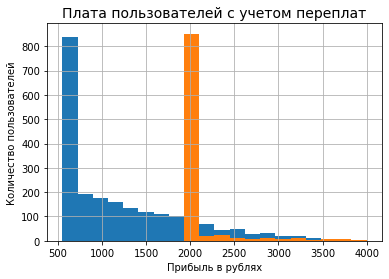

In [48]:
df.groupby('tariff_name')['total_proceed'].hist(bins=20, range = (550, 4000))
plt.title('Плата пользователей с учетом переплат', fontsize=14)
plt.xlabel("Прибыль в рублях")
plt.ylabel("Количество пользователей")
plt.show()

### Вывод
Если я правильно посчитала, то по графику получается пользователи тарифа "Смарт" переплачивают сверх ежемесячной платы чаще, но средняя выручка у пользователей тарифа "Ультра" выше.

In [49]:
# убираю лишние столбцы
df.drop(['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'], axis='columns', inplace=True)

In [50]:
df['total_proceed'] = df['total_proceed'].astype('int')


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 10 columns):
user_id          3201 non-null int64
month            3201 non-null int64
tariff_name      3201 non-null object
mb_used          3201 non-null float64
duration         3201 non-null float64
count_mes        3201 non-null float64
proceeds_cal     3201 non-null int64
proceeds_mes     3201 non-null int64
proceeds_inet    3201 non-null int64
total_proceed    3201 non-null int64
dtypes: float64(3), int64(6), object(1)
memory usage: 435.1+ KB


### <span style="color:blue"> Шаг 3: Анализ данных <span>

#### Анализ длительности звонков в месяц

Анализ по месяцам 

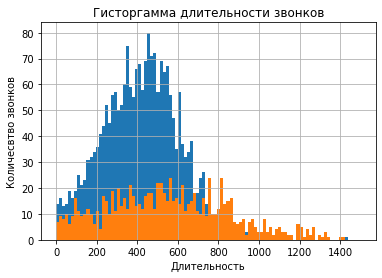

In [52]:
# отброшу пропущенные звонки и построю гистограмму длительности звонков
df.query('duration >0').groupby('tariff_name')['duration'].hist(bins=100, range = (0, 1500))
plt.title('Гисторгамма длительности звонков', fontsize=12)
plt.ylabel("Количесвтво звонков")
plt.xlabel("Длительность")
plt.show()

In [53]:
# Среднее
mean_smart=df_cal.query('tariff_name == "smart"')['duration'].mean()
mean_ultra=df_cal.query('tariff_name == "ultra"')['duration'].mean()

In [54]:
# Медиана
median_smart=df_cal.query('tariff_name == "smart"')['duration'].median()
median_ultra=df_cal.query('tariff_name == "ultra"')['duration'].median()

In [55]:
# Средняя длительность разговоров по пользователям в месяц для разных тарифов
df.pivot_table(index=['month', 'user_id'], columns = 'tariff_name', values='duration', aggfunc='mean')

tariff_name    smart   ultra
month user_id               
1     1005      95.0     NaN
      1032     380.0     NaN
      1045       9.0     NaN
      1055     551.0     NaN
      1071     194.0     NaN
...              ...     ...
12    1494     418.0     NaN
      1495       NaN  1031.0
      1496     518.0     NaN
      1497     545.0     NaN
      1499     492.0     NaN

[3201 rows x 2 columns]

In [56]:
# Диспeрсия smart
d1 = df_cal.query('tariff_name == "smart"')
variance_cal1 = np.var(d1['duration'])
variance_cal1

35.50902238284609

In [57]:
# Диспeрсия ultra
d2 = df_cal.query('tariff_name == "ultra"')
variance_cal2 = np.var(d2['duration'])
variance_cal2

35.515685427802744

In [58]:
# Стандартное отклонение smart
standard_deviation_cal1 = np.std(d1['duration'])
standard_deviation_cal1

5.9589447373546

In [59]:
# Стандартное отклонение ultra
standard_deviation_cal2 = np.std(d2['duration'])
standard_deviation_cal2

5.9595037904009045

In [60]:
stat_cal = pd.DataFrame({'stat_name':['среднее', 'медиана', 'дисперсия','стандартное отклонение'], 'smart':[mean_smart, median_smart, variance_cal1,standard_deviation_cal1], 'ultra':[mean_ultra, median_ultra, variance_cal2,standard_deviation_cal1]})
stat_cal

,stat_name,smart,ultra
0,среднее,7.148655,7.175400
1,медиана,6.000000,7.000000
2,дисперсия,35.509022,35.515685
3,стандартное отклонение,5.958945,5.958945


По длительности разговоров пользователи обоих тарифов похожи, почти одинаковое среднее, дисперсия и стандартное отклонение,  но у пользователей "Смарт" большее количество звонков.

#### Анализ количества сообщений в месяц

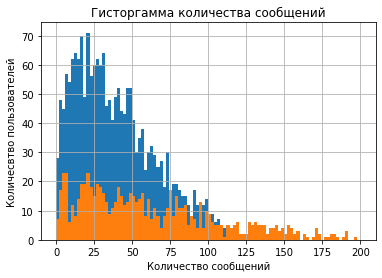

In [61]:
df.query('count_mes > 0').groupby('tariff_name')['count_mes'].hist(bins=100, range = (0, 200))
plt.title('Гисторгамма количества сообщений', fontsize=12)
plt.ylabel("Количесвтво пользователей")
plt.xlabel("Количество сообщений")
plt.show()

In [62]:
df_mes['count']=1
t = (df_mes.pivot_table(index=['month', 'user_id'], columns = 'tariff_name', values='count', aggfunc='sum'))
t.columns=['smart', 'ultra']
t.sample(5)

,,smart,ultra
month,user_id,,
4,1385,NaN,96.0
9,1064,33.0,NaN
11,1311,66.0,NaN
7,1359,5.0,NaN
9,1043,9.0,NaN


In [63]:
# Среднее smart
mean_smart = t['smart'].mean()
median_smart = t['smart'].median()

In [64]:
# Среднее ultra
mean_ultra = t['ultra'].mean()
median_ultra = t['ultra'].median()

In [65]:
# Диспeрсия smart
variance_mes1 = np.var(t['smart'])
variance_mes1

717.2208431102272

In [66]:
# Диспeрсия ultra
variance_mes2 = np.var(t['ultra'])
variance_mes2

2107.0055235156838

In [67]:
# Стандартное отклонение
standard_deviation_mes1 = np.std(t['smart'])
standard_deviation_mes1

26.78097912904282

In [68]:
# Стандартное отклонение
standard_deviation_mes2 = np.std(t['ultra'])
standard_deviation_mes2

45.90212983637779

По количеству отправляемых сообщений в месяц пользователи разных тарифов совсем не похожи. Среднее количество сообщений у Ультра почти в два раза больше, дисперсия в 3 раза больще и стандартное отклонение почти в два раза больше.

In [69]:
stat_mes = pd.DataFrame({'stat_name':['среднее', 'медиана', 'дисперсия','стандартное отклонение'], 'smart':[mean_smart, median_smart, variance_mes1,standard_deviation_mes1], 'ultra':[mean_ultra, median_ultra, variance_mes2,standard_deviation_mes1]})
stat_mes

,stat_name,smart,ultra
0,среднее,38.716441,61.161006
1,медиана,34.000000,51.000000
2,дисперсия,717.220843,2107.005524
3,стандартное отклонение,26.780979,26.780979


#### Анализ трафика в месяц

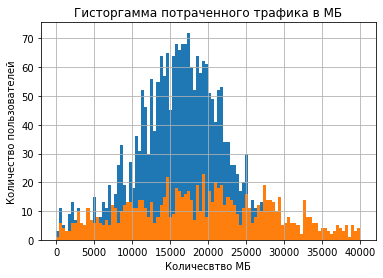

In [70]:
df.groupby('tariff_name')['mb_used'].hist(bins=100, range = (0, 40000))
plt.title('Гисторгамма потраченного трафика в МБ', fontsize=12)
plt.xlabel("Количесвтво МБ")
plt.ylabel("Количество пользователей")
plt.show()

In [71]:
# Среднее
mean_smart = df.query('tariff_name == "smart"')['mb_used'].mean()
mean_ultra = df.query('tariff_name == "ultra"')['mb_used'].mean()

In [72]:
# Медиана
median_smart = df.query('tariff_name == "smart"')['mb_used'].median()
median_ultra = df.query('tariff_name == "ultra"')['mb_used'].median()

In [73]:
# Диспeрсия smart
d1 = df.query('tariff_name == "smart"')
variance_inet1 = np.var(d1['mb_used'])
variance_inet1

34241826.05955689

In [74]:
# Диспeрсия ultra
d2 = df.query('tariff_name == "ultra"')
variance_inet2 = np.var(d2['mb_used'])
variance_inet2

98466665.28900848

In [75]:
# Стандартное отклонение smart
standard_deviation_inet1 = np.std(d1['mb_used'])
standard_deviation_inet1

5851.651566827683

In [76]:
# Стандартное отклонение ultra
standard_deviation_inet2 = np.std(d2['mb_used'])
standard_deviation_inet2

9923.037100052004

In [77]:
stat_inet = pd.DataFrame({'stat_name':['среднее', 'медиана', 'дисперсия','стандартное отклонение'], 'smart':[mean_smart, median_smart, variance_inet1,standard_deviation_inet1], 'ultra':[mean_ultra, median_ultra, variance_inet2,standard_deviation_inet1]})
stat_inet

,stat_name,smart,ultra
0,среднее,1.622294e+04,1.968868e+04
1,медиана,1.650864e+04,1.940903e+04
2,дисперсия,3.424183e+07,9.846667e+07
3,стандартное отклонение,5.851652e+03,5.851652e+03


Среднее значение расходуемых МБ отличается, но не так сильно как с сообщениями. А вот дисперсия Ультра почти в 3 раза больше и почти в 2 раза стандартное отклонение.

### <span style="color:blue"> Шаг 4: Проверка гипотезы <span>

Необходимо проверить:
1. средняя выручка пользователей тарифа «Ультра» больше чем у «Смарт»;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Гипотеза о выручке разных тарифов

In [78]:
df.pivot_table(index='tariff_name', values='total_proceed', aggfunc=('mean', 'count'))

,count,mean
tariff_name,,
smart,2227.0,1230.766951
ultra,974.0,2061.040041


In [79]:
# разделила на два датафрейма пользователей по тарифам
ultra = df.query('tariff_name == "ultra"')
smart = df.query('tariff_name == "smart"')

In [80]:
#дисперсия выручки Ультра
variance_ultra = np.var(ultra['total_proceed'])
variance_ultra

126997.54357125088

In [81]:
#дисперсия выручки Смарт
variance_smart = np.var(smart['total_proceed'])
variance_smart

616980.6367524012

По среднему из сводной таблицы видно, что выручка Ультра почти в два раза больше. Проверяю случайно ли так получилось. Для проверки использую метод scipy.stats.ttest_ind, поскольку я решила что это две разные генеральные совокупности.

 - Нулевая гипотеза Н0: средняя выручка пользователей тарифа «Ультра» равна средней выручке у «Смарт»
 - Альтернативная гипотеза Н1: средняя выручка пользователей тарифа «Ультра» больше чем у «Смарт»

In [82]:
#проверка нулевой гипотезы : средняя выручка пользователей тарифа «Ультра» равна выручке «Смарт»


u = ultra['total_proceed']
s = smart['total_proceed']

alpha = .01 

results = st.ttest_ind(
    u, 
    s, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue  < alpha / 2) and (u.mean() > s.mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.84224917082508e-297
Отвергаем нулевую гипотезу


#### Гипотеза о выручке в Мск и регионах

Соединяю в новую таблицу данные о выручке по пользователям и данные о городах пользователей.

In [83]:
df_city = df.merge(us, on='user_id')

Разделила на две выборки: пользователи из Москвы и пользователи из регионов.

In [84]:
moscow = df_city.query('city == "Москва"')
region = df_city.query('city != "Москва"')

In [85]:
#средняя выручка в Москве
moscow['total_proceed'].mean()

1505.039279869067

In [86]:
#средняя выручка в регионах
region['total_proceed'].mean()

1478.2980694980695

In [87]:
#дисперсия выручки в Москве
variance_moscow = np.var(moscow['total_proceed'])
variance_moscow

544974.2635962081

In [88]:
#дисперсия выручки в регионах
variance_region = np.var(region['total_proceed'])
variance_region

629925.1644364276

Дисперсии не равны, ставлю equal_var = False.

 - Нулевая  гипотеза Н0: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
 - Альтерантивная гипотеза Н1: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов

Так как в проекте не просят уточнить где выручка больше, а задание звучит как: "проверте гипотезу средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". Я решила тут оставить двухсторонюю гипотезу и проверить только на равенство.

In [89]:
#проверка нулевой гипотезы: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов


m = moscow['total_proceed']
r = region['total_proceed']

alpha = .01

results = st.ttest_ind(
    m, 
    r, equal_var = False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.427883078569677
Не получилось отвергнуть нулевую гипотезу


Значение pvalue большое. Это значит, что с очень большой вероятностью средняя выручка в Москве и регионах будет одинаковая.

Я тут сомневалась и пробовала метод scipy.stats.ttest_rel(), потому что не очень поняла разницу между rel и ind, но результат был одинаковый, нулевая гипотеза не отвергалась. Добавила тут equal_var = True, решила что выборки взяты из схожих по параметрам совокупностей, так как там есть представители обоих тарифов. 

### <span style="color:blue"> Вывод <span>

1. выручка от тарифа "Ультра" больше, чем от "Смарт"
2. средняя выручка в Москве и в регионах не отличается
 
Статистически выходит, что для оператора лучше оставить тариф "Ультра", но я ставя себя на место пользователя отказалась бы от такого тарифа. Если бы оператор сказал мне, что все тарифа "Смарт" больше не будет, переходи на "Ульта", скорее всего я сменила бы оператора. Т.к. стоимость тарифа "Ультра" в три раза больше. Даже в выборке из 500 человек тут, 351 пользуются "Смарт", при резком изменении тарифного плана оператор рискует потерять большую часть клиентов. 
 